# Final Project - Machine Learning Spring 2020
### - by Adam Salyers and Cassidy Carpenter

### Project Goal:
> We wanted to do our project on fastasy football, more specifically, creating a regression model that would predict
> what the rankings for the next year of players would be based on our model. We wanted this to be used so that we 
> could select the best matchup, free agents, and draft targets for leagues. 

### Libaries Used:
> We used the standard libraries (numpy, pandas, pyplot)
> We also used the following sklearn libraries

> `from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression`

> We imported train_test_split to easily get malleable data to run our model on
> Since this was a Regression model we needed to import the sklearn lirbary for running LinearRegression.

### Why Choose a Linear Regression Model?
> We chose a regression model and not a classification model because we are not categorizing each player into 
> draft vs. not draft, we are instead making a prediction from previous years data to predict what their FantsyPoint 
> ranking would be the next year. 

> Since our model is not just 1 variable, this is actually a Multiple Linear Regression which just means that we have 
> multiple parameters that influence a players ranking for their FantasyPoints.
> MLR is useful when dealing with a lot of predictor variables, and we started out with about 19 predictors thus
> found this to be the best option for our model.




In [1]:
##Import needed libraries
from math import exp
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

### What our raw data looks like 
> We got our data from : [Fantasy Football Data](https://www.dropbox.com/s/7q0679tjqacs4xv/Raw%20Data%2010yrs_v3.xlsx?dl=0​) this consists of Fantasy Football data from 2008-2018

> In excel we simply concatenated the top column header with the bottom column header to create a dataframe
> You can see the result in the cell's output below. 

### What were our first steps?

> First we imported the data using `pd.read_csv()`
> Then we separated the data into a even 80/20 split. 80% of the data (years 2008-2016) was our training set

> The other 20% of our data, (years 2017-2018) was our testing data. 

> Due to a large scope, we decided to only run our model on four positions in football: **QB (Quarter Back)**, **RB (Running Back)** , **WR (Wide Receiver)** , and the **TE (Tight End)**. This was simply to narrow our scope so we could focus on predicting the rankings for these four positions and not have to worry about all the other positions. 

> Next, we were able to drop some uneccesary stats for each of these positions. This inclused dropping the `rec_col` form our `qb_tr` or quarterback_training dataframe because QB's do not generally receieve. 

> We used simlar logic for the rest of the positions dropping unecessary columns. 

In [16]:
##Import CSV
df = pd.read_csv ('footballdata.csv')
#Lets get rid of some of the stuff we dont need
#df.drop(['PosRank'])
#First we need to seperate all our data by year, then by position
#We have 10 years of data from 2008 to 2018
#Lets make some training and testing data, lets figure, I like 80% train 20% test for this
yr_train = list(range(2008, 2017))
yr_test = list(range(2017,2019))
x_train = df.loc[df['Year'].isin(yr_train)]
x_test = df.loc[df['Year'].isin(yr_test)]

rb_tr = x_train[x_train['FantPos'] == 'RB']
qb_tr = x_train[x_train['FantPos'] == 'QB']
wr_tr = x_train[x_train['FantPos'] == 'WR']
te_tr = x_train[x_train['FantPos'] == 'TE']

#While we do have to take into account running QB's and high receiving RB's we can generally split the categories
rush_col = ['RushAtt', 'RushYds', 'RushY/A', 'RushTD']
rec_col = ['RecTgt', 'Receptions', 'RecYds', 'RecY/R', 'RecTD']
pass_col = ['PassAtt', 'PassCmp', 'PassYds', 'PassTD', 'PassInt']

rbs = rb_tr.drop(pass_col, axis=1)
wrs = wr_tr.drop(pass_col, axis=1)
tes = te_tr.drop(rush_col+pass_col, axis=1)
qbs = qb_tr.drop(rec_col, axis=1)

rbs.head()

,Year,Name,Tm,FantPos,Age,Games,GamesStarted,RushAtt,RushYds,RushY/A,...,RecTgt,Receptions,RecYds,RecY/R,RecTD,FantPt,PPR,PPG,PPRPG,PosRank
3,2008,DeAngelo Williams,CAR,RB,25.0,16.0,16.0,273.0,1515.0,5.55,...,30.0,22.0,121.0,5.50,2.0,286.0,308.0,17.875,19.25,1.0
6,2008,Michael Turner,ATL,RB,26.0,16.0,16.0,376.0,1699.0,4.52,...,9.0,6.0,41.0,6.83,0.0,276.0,282.0,17.25,17.625,2.0
10,2008,Adrian Peterson,MIN,RB,23.0,16.0,15.0,363.0,1760.0,4.85,...,39.0,21.0,125.0,5.95,0.0,249.0,270.0,15.5625,16.875,3.0
11,2008,Matt Forte,CHI,RB,23.0,16.0,16.0,316.0,1238.0,3.92,...,76.0,63.0,477.0,7.57,4.0,244.0,307.0,15.25,19.1875,4.0
12,2008,Thomas Jones,NYJ,RB,30.0,16.0,14.0,290.0,1312.0,4.52,...,42.0,36.0,207.0,5.75,2.0,242.0,278.0,15.125,17.375,5.0


### Next Steps: Creating arrays the from current year to the next year

> So we ran into a problem with our data and realized if we wanted to predict their Fantasy Point rankings for the **NEXT** year.

> Thus we needed to create X arrays for each position, y arrays for each position, as well as check that the player was playing in the previous year if we are currently predicting the current year. 

> In simpler terms, when predicting a player they must both exist in the 'prev' year and the current testing year to make a prediction. 

> So what is our code doing, first we are getting the data from the current position and then
> Getting the data from the previous year 

> `prev = pos[pos['Year'] == year-1]`

> Then we are checking if the Name of the player exists in both the prev and current year

>`players = players.loc[players['Name'].isin(prev['Name'])]
prev = prev.loc[prev['Name'].isin(players['Name'])]`

> Then we just append those values to our `tempX` according to their position. 
> This gives us 8 arrays (4 X arrays for each position and 4 y arrays for each position)

In [17]:
#so now how do we set up our x_train and y_train, we want to ideally project the next seasons points
RBxs = []
WRxs = []
TExs = []
QBxs = []
RBys = []
WRys = []
TEys = []
QBys = []
#These are all of our training x's and y's seperated by position. Each one is a list of a seperate years so we have basically 8 seperate datasets to
#help train on.
count = 0
for pos in [rbs, wrs, tes, qbs]:
    tempx = []
    tempy = []
    #Create our temporary arrays to be replaced by our position arrays defined above
    for year in range(2009,2017):
        #get the data from this year, at the correct position
        players = pos[pos['Year'] == year]

        #get the data from the previous year that will be used as our x
        prev = pos[pos['Year'] == year-1]

        #Only take the players on which we have data from previous years
        players = players.loc[players['Name'].isin(prev['Name'])]

        #Make sure we are only using data that will inform our prediction, not for someone who does not stay around
        prev = prev.loc[prev['Name'].isin(players['Name'])]
        
        #Sort the values by name so we can add to the array
        prev = prev.sort_values(by=['Name'])
        players = players.sort_values(by=['Name'])
        prev = prev.drop(['PosRank'], axis=1)
        
        #make sure we add the year to our list
        tempx.append(prev)
        tempy.append(players['FantPt'])
        
    #assign the temp to the correct variable
    if count == 0: 
        RBxs = tempx
        RBys = tempy
    if count == 1: 
        WRxs = tempx
        WRys = tempy
    if count == 2: 
        TExs = tempx
        TEys = tempy
    if count == 3: 
        QBxs = tempx
        QBys = tempy
    count += 1


### Trimming data (Again)

> So now we have our X and y data. 

> We realized there was some duplicate data and we concatenated our Pos X arrays and our corresponding Pos y arrays.
> Then we dropped needless information like `Name` which acted basically as a index, `Year` because we know how many 
> years there is, `Tm` or team because it does not really effect ranking, and a lot of other columns for similar reasons. 

In [4]:
#Ok now if we are going to train our data we need to get rid of some datapoints that won't do us much good.
#Ok well for regression we probably don't need the names, teams, Positions, now that weve already seperated them
#GamesStarted, lets cut that. Since all of our point data is contained within our other points we can also cut
#PPR, PPG, PPRPG, and FantPt.
#Lets start by cutting those!
RBxs = pd.concat(RBxs)
RBys = pd.concat(RBys)
RBxs = RBxs.drop(['Year','Name','Tm','FantPos','GamesStarted','FantPt','PPR','PPG','PPRPG'], axis=1)
RBxs.head()

,Age,Games,RushAtt,RushYds,RushY/A,RushTD,RecTgt,Receptions,RecYds,RecY/R,RecTD
322,33.0,6.0,8.0,43.0,5.38,0.0,12.0,9.0,52.0,5.78,1.0
10,23.0,16.0,363.0,1760.0,4.85,10.0,39.0,21.0,125.0,5.95,0.0
218,22.0,15.0,67.0,355.0,5.30,1.0,6.0,5.0,42.0,8.40,1.0
165,31.0,8.0,74.0,294.0,3.97,3.0,14.0,11.0,32.0,2.91,0.0
265,29.0,16.0,8.0,21.0,2.63,0.0,18.0,13.0,138.0,10.62,2.0


In [5]:
#Lets just double check make sure our indices are lining up
print("X shape: ", RBxs.shape)
print("Y shape: ", RBys.shape)

X shape:  (914, 11)
Y shape:  (914,)


### Graphs

> Now we created a scatter plot to see the correlation between all the parameters in our X array. 
> Looking at the graph below, for `RB` or Running Backs, there is a high correlation for `RushAtt`. 
> This indicates a good parameter to keep, probably our best parameter for this position. 

> Next we can look at parameters that do not have any correlation. This happens to be `Age` which makes sense because typically American Football players are all the same age bracket. We can also see the number of Receiveing Y/R (`RecY/R`) has low correlation as well as Receiving Touchdowns (`RecTD`). Thus we dropped these columns from our model 

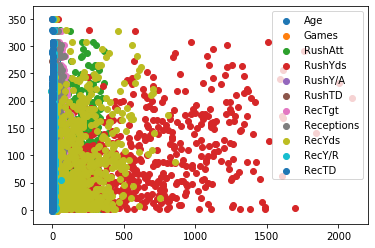

In [6]:
#Ok our shapes line up so lets try to visualize all our points against our y
for col in RBxs.columns:
    plt.scatter(RBxs[col], RBys)
plt.legend(RBxs.columns)
plt.show()

### Graphs Continued 

> Now our graph (see below) looks a lot better. We have more correlation amoung the parameters, but it still is not perfect. Thus we decided to separate each parameter and graph it in a scatter plot separately. This would help us determine any other parameters that have little to no correlation with our desired Fantasy Points. 


> Take a look at the graphs below to see what this looked like. From there, we determined that number of `Games` had low correlation, as well as `RushY/A`

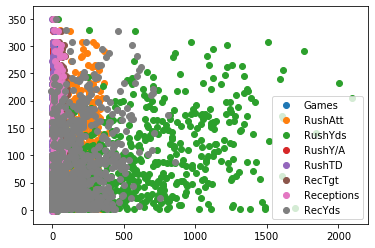

In [7]:
#Looks like we have a few more variables that just do nor corelate whatsoever. Age, RecY/R, RecTD. Lets get rid of these
RBxs = RBxs.drop(['Age', 'RecY/R', 'RecTD'], axis=1)
for col in RBxs.columns:
    plt.scatter(RBxs[col], RBys)
plt.legend(RBxs.columns)
plt.show()

Correlation is: [[1.         0.08275439]
 [0.08275439 1.        ]]


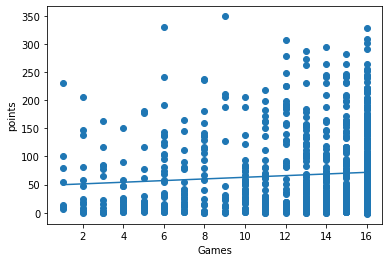

Correlation is: [[1.         0.51032833]
 [0.51032833 1.        ]]


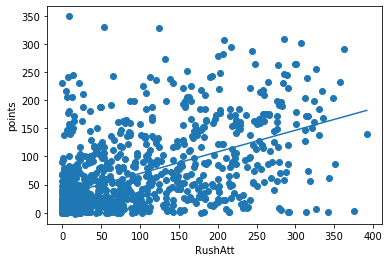

Correlation is: [[1.         0.52004181]
 [0.52004181 1.        ]]


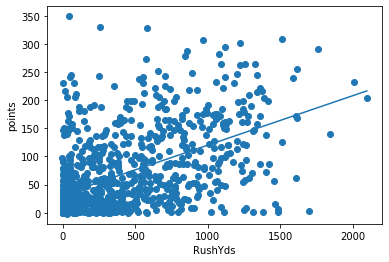

Correlation is: [[1.         0.20397989]
 [0.20397989 1.        ]]


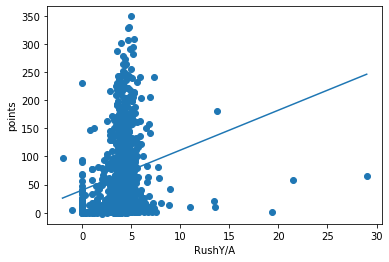

Correlation is: [[1.         0.42819632]
 [0.42819632 1.        ]]


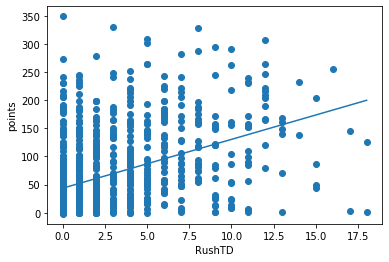

Correlation is: [[1.         0.37707049]
 [0.37707049 1.        ]]


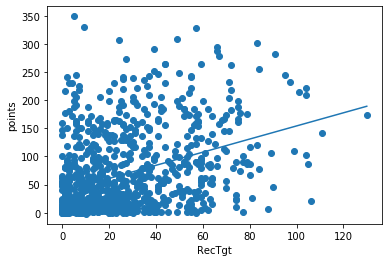

Correlation is: [[1.         0.37309615]
 [0.37309615 1.        ]]


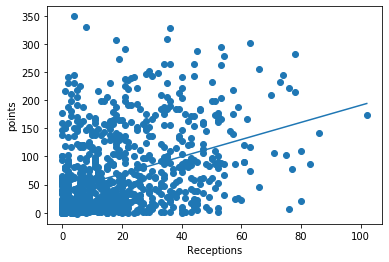

Correlation is: [[1.         0.34853575]
 [0.34853575 1.        ]]


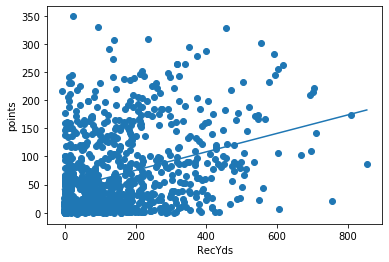

In [8]:
#Looks a lot better, but it is still really hard to see the data, lets just get graphs of all the individual
#points to get a better idea
RBxs = RBxs.fillna(value=0)
RBys = RBys.fillna(value=0)
for col in RBxs.columns:
    x = RBxs[col]
    y = RBys
    corr = np.corrcoef(x, y)
    print("Correlation is:",corr)
    plt.scatter(x, y)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.xlabel(col)
    plt.ylabel("points")
    plt.show()

### Last Data trim

> Like we mentioned above, through looking at each of the parameters indiviually against the number of Fantasy Points (`FantPt`), we determined the best parameters to use for our model. 

In [9]:
#Awesome looks like the two fat pices we still need to trim are games, and RushY/A. Both of these have a lower correlation
RBxs = RBxs.drop(['Games', 'RushY/A'], axis=1)
RBxs.head()

,RushAtt,RushYds,RushTD,RecTgt,Receptions,RecYds
322,8.0,43.0,0.0,12.0,9.0,52.0
10,363.0,1760.0,10.0,39.0,21.0,125.0
218,67.0,355.0,1.0,6.0,5.0,42.0
165,74.0,294.0,3.0,14.0,11.0,32.0
265,8.0,21.0,0.0,18.0,13.0,138.0


### Final Steps

> Now time to `train_test_split()` and `fit()` our model using `LinearRegression()`

Correlation is: [[1.         0.51826117]
 [0.51826117 1.        ]]


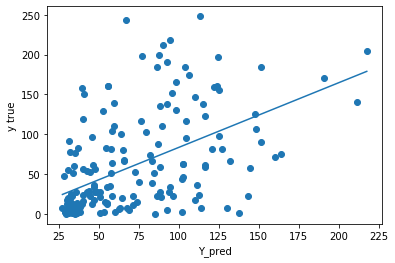

In [10]:
#These make sense as our top fantasy predictors now lets see how linear regression performs
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(RBxs, RBys, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

y_pred = regressor.predict(X_test)
y = y_test.values.tolist()
x = list(y_pred)
#To get a better idea of our data lets plot x vs y

corr = np.corrcoef(x, y)
print("Correlation is:",corr)
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel("Y_pred")
plt.ylabel("y true")   
plt.show()


### Other Positions

#### QB
> Lets Repeat the process for the rest of our positions!

In [11]:
QBxs = pd.concat(QBxs)
QBys = pd.concat(QBys)
QBxs = QBxs.drop(['Year','Name','Tm','FantPos','Games','GamesStarted','FantPt','PPR','PPG','PPRPG'], axis=1)
QBxs.head()

,Age,PassCmp,PassAtt,PassYds,PassTD,PassInt,RushAtt,RushYds,RushY/A,RushTD
1,25.0,341.0,536.0,4038.0,28.0,13.0,56.0,207.0,3.70,4.0
32,26.0,281.0,469.0,3301.0,17.0,15.0,34.0,101.0,2.97,2.0
176,24.0,45.0,89.0,518.0,2.0,2.0,5.0,21.0,4.20,0.0
30,39.0,343.0,522.0,3472.0,22.0,22.0,21.0,43.0,2.05,1.0
396,25.0,20.0,29.0,151.0,0.0,0.0,0.0,0.0,NaN,0.0


>We can see that we have far fewer datapoints to analyze we don't need to do as much trimming but lets see what we can do

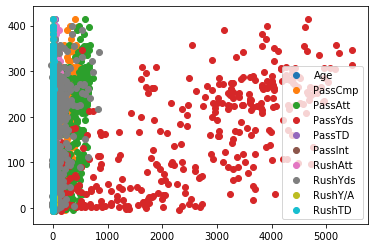

In [12]:
for col in QBxs.columns:
    plt.scatter(QBxs[col], QBys)
plt.legend(QBxs.columns)
plt.show()
QBxs = QBxs.drop(['RushTD','RushAtt','Age','RushY/A'], axis=1)


>Ok looks like we need to cut the variables shown above! Now lets check another Model

Correlation is: [[1.         0.73449774]
 [0.73449774 1.        ]]


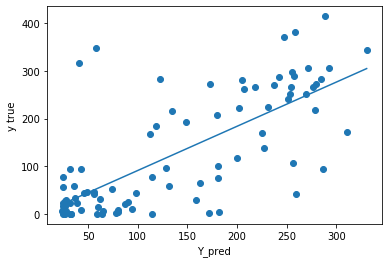

In [13]:
from sklearn.linear_model import LinearRegression

QBxs = QBxs.fillna(value=0)
QBys = QBys.fillna(value=0)

X_train, X_test, y_train, y_test = train_test_split(QBxs, QBys, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

y_pred = regressor.predict(X_test)
y = y_test.values.tolist()
x = list(y_pred)
#To get a better idea of our data lets plot x vs y

corr = np.corrcoef(x, y)
print("Correlation is:",corr)
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel("Y_pred")
plt.ylabel("y true")   
plt.show()

>Much better accuracy! Actually, really really good accuracy compared to Running Backs

#### WR

In [19]:
WRxs = pd.concat(WRxs)
WRys = pd.concat(WRys)
WRxs = WRxs.drop(['Year','Name','Tm','FantPos','Games','GamesStarted','FantPt','PPR','PPG','PPRPG'], axis=1)
WRxs.head()

,Age,RushAtt,RushYds,RushY/A,RushTD,RecTgt,Receptions,RecYds,RecY/R,RecTD
339,23.0,5.0,53.0,10.60,0.0,19.0,11.0,78.0,7.09,0.0
24,27.0,0.0,0.0,NaN,0.0,171.0,115.0,1575.0,13.70,8.0
298,29.0,0.0,0.0,NaN,0.0,28.0,13.0,213.0,16.38,0.0
44,28.0,9.0,67.0,7.44,0.0,127.0,89.0,1038.0,11.66,11.0
48,27.0,2.0,22.0,11.00,0.0,138.0,83.0,1248.0,15.04,7.0


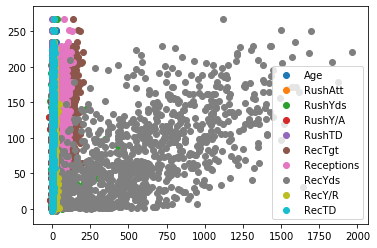

In [20]:
for col in WRxs.columns:
    plt.scatter(WRxs[col], WRys)
plt.legend(WRxs.columns)
plt.show()

WRxs = WRxs.drop(['RushAtt','Age','RushY/A'], axis=1)

Correlation is: [[1.         0.61768939]
 [0.61768939 1.        ]]


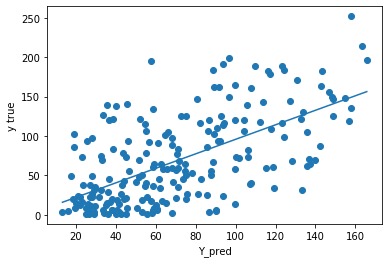

In [21]:
WRxs = WRxs.fillna(value=0)
WRys = WRys.fillna(value=0)

X_train, X_test, y_train, y_test = train_test_split(WRxs, WRys, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

y_pred = regressor.predict(X_test)
y = y_test.values.tolist()
x = list(y_pred)
#To get a better idea of our data lets plot x vs y

corr = np.corrcoef(x, y)
print("Correlation is:",corr)
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel("Y_pred")
plt.ylabel("y true")   
plt.show()

#### TE

In [22]:
TExs = pd.concat(TExs)
TEys = pd.concat(TEys)
TExs = TExs.drop(['Year','Name','Tm','FantPos','Games','GamesStarted','FantPt','PPR','PPG','PPRPG'], axis=1)
TExs.head()

,Age,RecTgt,Receptions,RecYds,RecY/R,RecTD
256,31.0,41.0,24.0,257.0,10.71,1.0
138,24.0,53.0,34.0,454.0,13.35,7.0
98,28.0,92.0,60.0,704.0,11.73,8.0
438,28.0,6.0,3.0,26.0,8.67,0.0
343,24.0,18.0,11.0,104.0,9.45,0.0


Correlation is: [[1.         0.56983008]
 [0.56983008 1.        ]]


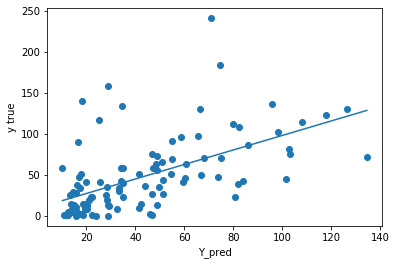

In [23]:
TExs = TExs.drop(['Age'], axis=1)

TExs = TExs.fillna(value=0)
TEys = TEys.fillna(value=0)

X_train, X_test, y_train, y_test = train_test_split(TExs, TEys, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

y_pred = regressor.predict(X_test)
y = y_test.values.tolist()
x = list(y_pred)
#To get a better idea of our data lets plot x vs y

corr = np.corrcoef(x, y)
print("Correlation is:",corr)
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel("Y_pred")
plt.ylabel("y true")   
plt.show()

## Conclusion

> How did our models turn out? Well looking at the graphs, the y_pred values had high correlation to the y_true values.
> I would consider this a success. Due to this high correlation it means that our MLR is predicting very well based on the parametric values it is given. This has a lot to do with us looking at the correlation of `FantPt` with the rest of the parametric values to find the highest correlation and completely dropping the ones that were excess. We could have user hyper-parameter tuning libraries, but we decided since there weren't that mant parameters for each postion it would be better to get a visual idea of the correlation between the paratmeters, and from there it was easy to remove ones that simply were not aiding our model to predict.

### What we would add:
> We would of course like to have the predictions for all positions in football, so that would some scope that we could add to this project in the future. Additionally, we could try to automate creating each model for each position instead of doing all the positions separately, but that was out of scope for the time we had on this project.

### How could this be used in the future:
> Hundreds of thousands of American Football fans pour their time, money, and effort into playing Fantasy Football. We could easily offer this as a tool for trying to get the best draft picks, free agents, and matchups (like we set out to do) for many of the users of Fantasy Football. We could even monotize it potentially if enough people were willing to use the alrogirthm (and if the algorithm was accurate enough for the coming years of Football).